$$
\begin{align}
u_{n+1/2}   & = u_n + \frac{\Delta t}{2} f(u_n) \\
u_{n+1} & = u_n + \Delta t \,\, f(u_{n+1/2})
\end{align}
$$

This method is known as the *explicit midpoint method* or the *modified Euler method*, and it is a second-order method. Notice that we had to apply the right-hand side, $~f(u)$, twice. This idea can be extended: we could imagine estimating additional points between $u_{n}$ and $u_{n+1}$ and evaluating $~f(u)$ at the intermediate points to get higher accuracy—that's the idea behind Runge-Kutta methods.

In [5]:
import math
import numpy
from matplotlib import pyplot
%matplotlib inline

In [6]:
# Set the font family and size to use for Matplotlib figures.
pyplot.rcParams['font.family'] = 'serif'
pyplot.rcParams['font.size'] = 16

In [17]:
# Set parameters.
g = 9.81  # gravitational acceleration (m.s^{-2})
vt = 4.9  # trim velocity (m.s)
CD = 1.0 / 5.0  # drag coefficient
CL = 1.0  # lift coefficient

# Set initial conditions.
v0 = 6.5  # start at the trim velocity
theta0 = 2 # trajectory angle
x0 = 0.0  # horizontal position
y0 = 2.0  # vertical position (altitude)

### Functions

In [8]:
def rhs_phugoid(u, CL, CD, g, vt):
    """
    Returns the right-hand side of the phugoid system of equations.
    
    Parameters
    ----------
    u : list or numpy.ndarray
        Solution at the previous time step
        as a list or 1D array of four floats.
    CL : float
        Lift coefficient.
    CD : float
        Drag coefficient.
    g : float
        Gravitational acceleration.
    vt : float
        Trim velocity.
    
    Returns
    -------
    rhs : numpy.ndarray
        The right-hand side of the system
        as a 1D array of four floats.
    """
    v, theta, x, y = u
    rhs = numpy.array([-g * math.sin(theta) - CD / CL * g / vt**2 * v**2,
                       -g * math.cos(theta) / v + g / vt**2 * v,
                       v * math.cos(theta),
                       v * math.sin(theta)])
    return rhs


def euler_step(u, f, dt, *args):
    """
    Returns the solution at the next time step using Euler's method.
    
    Parameters
    ----------
    u : numpy.ndarray
        Solution at the previous time step
        as a 1D array of floats.
    f : function
        Function to compute the right-hand side of the system.
    dt : float
        Time-step size.
    args : tuple, optional
        Positional arguments to pass to the function f.
    
    Returns
    -------
    u_new : numpy.ndarray
        The solution at the next time step
        as a 1D array of floats.
    """
    u_new = u + dt * f(u, *args)
    return u_new

def rk2_step(u, f, dt, *args):
    """
    Returns the solution at the next time step using 2nd-order
    Runge-Kutta method.
    
    Parameters
    ----------
    u : numpy.ndarray
        Solution at the previous time step
        as a 1D array of floats.
    f : function
        Function to compute the right-hand side of the system.
    dt : float
        Time-step size.
    args : tuple, optional
        Positional arguments to pass to the function f.
    
    Returns
    -------
    u_new : numpy.ndarray
        The solution at the next time step
        as a 1D array of floats.
    """
    u_star = u + 0.5 * dt * f(u, *args)
    u_new = u + dt * f(u_star, *args)
    return u_new

def l1_diff(u_coarse, u_fine, dt):
    """
    Returns the difference in the L1-norm between the solution on
    a coarse grid and the solution on a fine grid.
    
    Parameters
    ----------
    u_coarse : numpy.ndarray
        Solution on the coarse grid as a 1D array of floats.
    u_fine : numpy.ndarray
        Solution on the fine grid as a 1D array of floats.
    dt : float
        Time-step size.
    
    Returns
    -------
    diff : float
        The difference between the two solution in the L1-norm
        scaled by the time-step size.
    """
    N_coarse = u_coarse.shape[0]
    N_fine = u_fine.shape[0]
    ratio = math.ceil(N_fine / N_coarse)
    diff = dt * numpy.sum(numpy.abs(u_coarse - u_fine[::ratio]))
    return diff

In [9]:
def rk2_output(T, dt):
    
    N = int(T/dt) + 1
    
# Create array to store solution at each time step
    u_rk2 = numpy.empty((N,4))

# Set initial conditions
    u_rk2[0] = numpy.array([v0, theta0, x0, y0])

# Time integration with rk2 method

    for n in range(N-1):
        u_rk2[n+1] = rk2_step(u_rk2[n], rhs_phugoid, dt, CL, CD, g, vt)
    
    return u_rk2

In [10]:
def euler_output(T, dt):
    
    N = int(T/dt) + 1
    
# Create array to store solution at each time step
    u_euler = numpy.empty((N,4))

# Set initial conditions
    u_euler[0] = numpy.array([v0, theta0, x0, y0])

# Time integration with rk2 method

    for n in range(N-1):
        u_euler[n+1] = euler_step(u_euler[n], rhs_phugoid, dt, CL, CD, g, vt)
    
    return u_euler

In [11]:
#time check for rk2 method
import time

tic1 = time.time()
rk2_output(15.0, 0.01)
print(rk2_output(15.0, 0.01)[:, 3])
toc1 = time.time()
print('time for rk2:'+ str(1000*(toc1 - tic1)) + 'ms')



[  2.           2.05903993   2.11743993 ... -11.92555093 -11.93507676
 -11.94460233]
time for rk2:98.94514083862305ms


In [12]:
#time check for euler method
import time

tic2 = time.time()
euler_output(15.0, 0.01)
print(euler_output(15.0, 0.01)[:,3])
toc2 = time.time()
print('time for euler:'+ str(1000*(toc2 - tic2)) + 'ms')


[  2.           2.05934144   2.11806866 ... -11.84219204 -11.85172165
 -11.86125079]
time for euler:68.95589828491211ms


In [13]:
# Set the list of time-step sizes to investigate.
dt_values = [0.1, 0.05, 0.01, 0.005]

In [14]:
def rk2_multiple(T):
    
    u_values_rk2 = []
    
    for dt in dt_values: 
        
        u_values_rk2.append(rk2_output(T, dt))
        
    
    return u_values_rk2

In [15]:
def euler_multiple(T):
    
    u_values_euler = []
    
    for dt in dt_values: 
        
        u_values_euler.append(euler_output(T, dt))
        
    
    return u_values_euler

In [18]:
#checking if the function works properly. len(rk2_mutiple...) = no. of dt values
rk2_multiple(15.0)
print(len(rk2_multiple(15.0)))

#checking if correct output is obtained for the function
#print(rk2_multiple(15.0)[0][:,3])

#checking if the function works properly. len(rk2_mutiple...) = no. of dt values
euler_multiple(15.0)
print(len(euler_multiple(15.0)))

#checking if correct output is obtained for the function
#print(euler_multiple(15.0)[0][:,3])

4
4


In [19]:
def plot_rk2_multiple(T):
    
    for i in range(len(dt_values)):
        
        idx_negative_rk2 = numpy.where(rk2_multiple(T)[i][:,3] < 0.0)[0]
        
        if len(idx_negative_rk2) == 0:
            idx_ground_rk2 = N-1
            print('rk2, not landed yet')
        else: 
            idx_ground_rk2 = idx_negative_rk2[0]
        
        x_rk2 = rk2_multiple(T)[i][:,2]
        y_rk2 = rk2_multiple(T)[i][:,3]
        
        #plotting curve for each dt_value
        
        # Plot the glider's path for both schemes.
        pyplot.figure(figsize=(9.0, 6.0))
        pyplot.subplot(121)
        pyplot.grid()
        pyplot.xlabel('x')
        pyplot.ylabel('y')
        #pyplot.plot(x_euler[:idx_ground_euler], y_euler[:idx_ground_euler],
                    #label='Euler')
        pyplot.plot(x_rk2[:idx_ground_rk2], y_rk2[:idx_ground_rk2],
                    label='RK2')
        pyplot.legend();
        # Let's take a closer look!
        pyplot.subplot(122)
        pyplot.grid()
        pyplot.xlabel('x')
        pyplot.ylabel('y')
        #pyplot.plot(x_euler, y_euler, label='Euler')
        pyplot.plot(x_rk2, y_rk2, label='RK2')
        pyplot.xlim(0.0, 5.0)
        pyplot.ylim(1.8, 2.5);
        print('Distance traveled, rk2, dt_value', i,':',' {:.3f}'.format(x_rk2[idx_ground_rk2 - 1]))
        print('Time taken, rk2, dt_value', i,':', '{:.3f}'.format(dt_values[i]*(idx_ground_rk2 -1)))

Distance traveled, rk2, dt_value 0 :  -2.369
Time taken, rk2, dt_value 0 : 0.900
Distance traveled, rk2, dt_value 1 :  -2.258
Time taken, rk2, dt_value 1 : 0.950
Distance traveled, rk2, dt_value 2 :  -2.232
Time taken, rk2, dt_value 2 : 0.960
Distance traveled, rk2, dt_value 3 :  -2.217
Time taken, rk2, dt_value 3 : 0.965


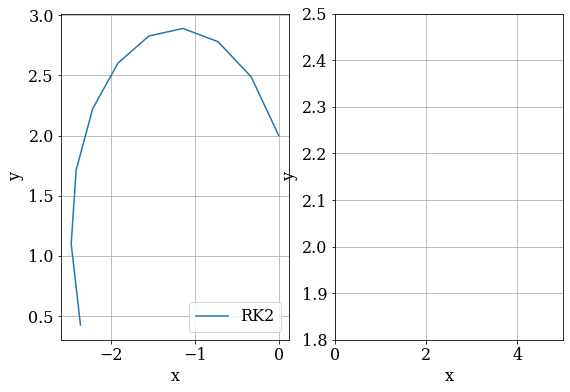

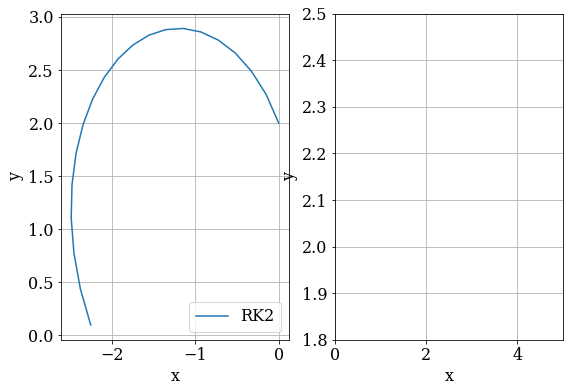

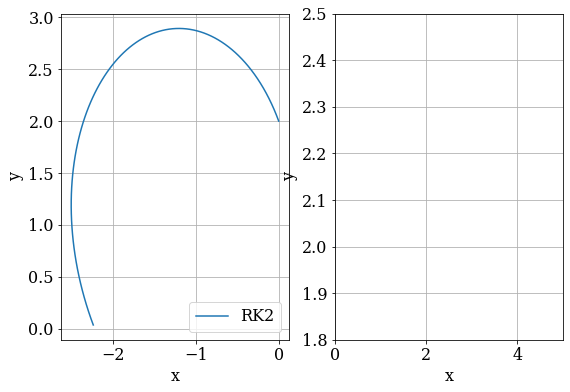

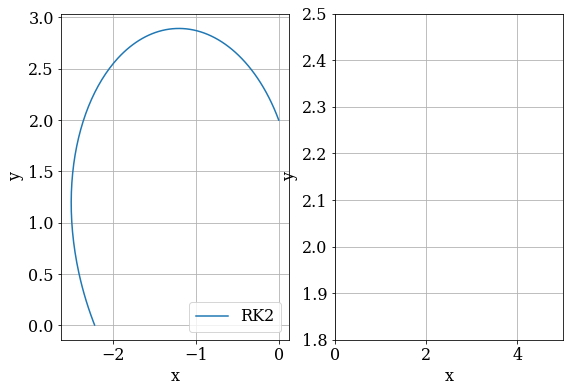

In [20]:
plot_rk2_multiple(15.0)

In [67]:
def plot_euler_multiple(T):
    
    for i in range(len(dt_values)):
        
        idx_negative_euler = numpy.where(euler_multiple(T)[i][:,3] < 0.0)[0]
        
        if len(idx_negative_euler) == 0:
            idx_ground_euler = N-1
            print('euler, not landed yet')
        else: 
            idx_ground_euler = idx_negative_euler[0]
        
        x_euler = euler_multiple(T)[i][:,2]
        y_euler = euler_multiple(T)[i][:,3]
        
        #plotting curve for each dt_value
        
        # Plot the glider's path for both schemes.
        pyplot.figure(figsize=(9.0, 6.0))
        pyplot.subplot(121)
        pyplot.grid()
        pyplot.xlabel('x')
        pyplot.ylabel('y')
        #pyplot.plot(x_euler[:idx_ground_euler], y_euler[:idx_ground_euler],
                    #label='Euler')
        pyplot.plot(x_euler[:idx_ground_euler], y_euler[:idx_ground_euler],
                    label='Euler')
        pyplot.legend();
        # Let's take a closer look!
        pyplot.subplot(122)
        pyplot.grid()
        pyplot.xlabel('x')
        pyplot.ylabel('y')
        #pyplot.plot(x_euler, y_euler, label='Euler')
        pyplot.plot(x_euler, y_euler, label='Euler')
        pyplot.xlim(0.0, 5.0)
        pyplot.ylim(1.8, 2.5);
        print('Distance traveled, euler, dt_value', i,':',' {:.3f}'.format(x_euler[idx_ground_euler - 1]))
        print('Time taken, euler, dt_value', i,':', '{:.3f}'.format(dt_values[i]*(idx_ground_euler -1)))

Distance traveled, euler, dt_value 0 :  10.562
Time taken, euler, dt_value 0 : 2.300
Distance traveled, euler, dt_value 1 :  14.783
Time taken, euler, dt_value 1 : 3.150
Distance traveled, euler, dt_value 2 :  14.550
Time taken, euler, dt_value 2 : 3.080
Distance traveled, euler, dt_value 3 :  14.556
Time taken, euler, dt_value 3 : 3.080


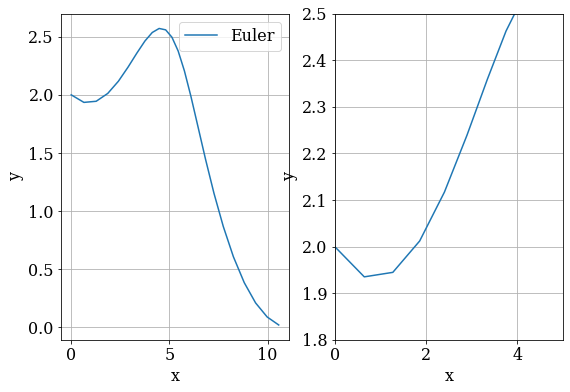

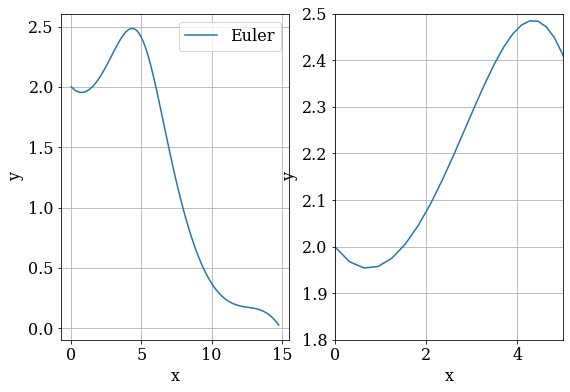

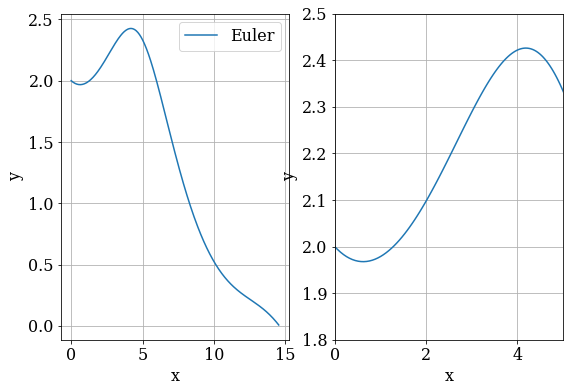

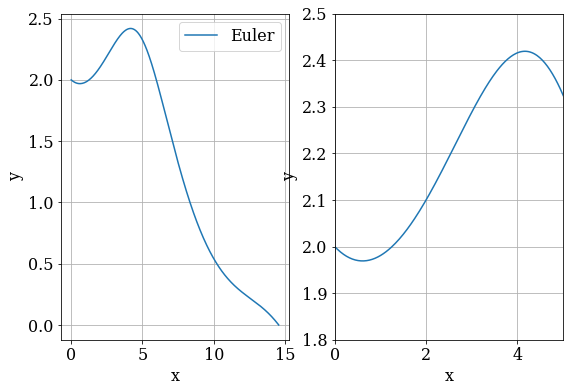

In [68]:
plot_euler_multiple(15.0)

In [69]:
def plot_combined_rk2_euler(T):
    
    for i in range(len(dt_values)):
        
        idx_negative_rk2 = numpy.where(rk2_multiple(T)[i][:,3] < 0.0)[0]
        
        if len(idx_negative_rk2) == 0:
            idx_ground_rk2 = N-1
            print('rk2, not landed yet')
        else: 
            idx_ground_rk2 = idx_negative_rk2[0]
        
        x_rk2 = rk2_multiple(T)[i][:,2]
        y_rk2 = rk2_multiple(T)[i][:,3]
        
        idx_negative_euler = numpy.where(euler_multiple(T)[i][:,3] < 0.0)[0]
        
        if len(idx_negative_euler) == 0:
            idx_ground_euler = N-1
            print('euler, not landed yet')
        else: 
            idx_ground_euler = idx_negative_euler[0]
        
        x_euler = euler_multiple(T)[i][:,2]
        y_euler = euler_multiple(T)[i][:,3]
        
        #plotting curve for each dt_value
        
        # Plot the glider's path for both schemes.
        pyplot.figure(figsize=(9.0, 6.0))
        pyplot.subplot(121)
        pyplot.grid()
        pyplot.xlabel('x')
        pyplot.ylabel('y')
        #pyplot.plot(x_euler[:idx_ground_euler], y_euler[:idx_ground_euler],
                    #label='Euler')
        pyplot.plot(x_rk2[:idx_ground_rk2], y_rk2[:idx_ground_rk2],
                    label='RK2')
        pyplot.plot(x_euler[:idx_ground_euler], y_euler[:idx_ground_euler],
                    color = 'C3', label='Euler')
        pyplot.legend();
        # Let's take a closer look!
        pyplot.subplot(122)
        pyplot.grid()
        pyplot.xlabel('x')
        pyplot.ylabel('y')
        #pyplot.plot(x_euler, y_euler, label='Euler')
        pyplot.plot(x_rk2, y_rk2, label='RK2')
        pyplot.plot(x_euler, y_euler, color = 'C3', label='Euler')
        pyplot.xlim(0.0, 1.0)
        pyplot.ylim(1.8, 2.0);
        print('Distance traveled, rk2, dt_value', i,':',' {:.3f}'.format(x_rk2[idx_ground_rk2 - 1]))
        print('Time taken, rk2, dt_value', i,':', '{:.3f}'.format(dt_values[i]*(idx_ground_rk2 -1)))
    

Distance traveled, rk2, dt_value 0 :  14.186
Time taken, rk2, dt_value 0 : 3.000
Distance traveled, rk2, dt_value 1 :  14.422
Time taken, rk2, dt_value 1 : 3.050
Distance traveled, rk2, dt_value 2 :  14.516
Time taken, rk2, dt_value 2 : 3.070
Distance traveled, rk2, dt_value 3 :  14.516
Time taken, rk2, dt_value 3 : 3.070


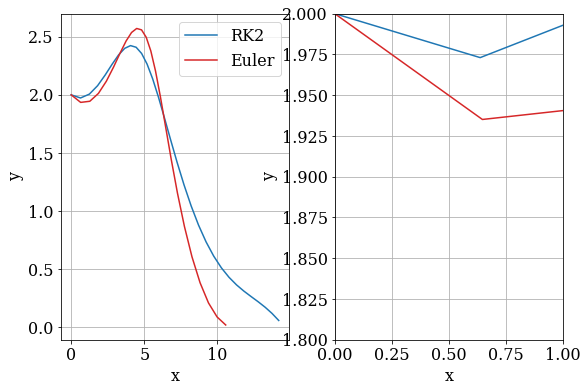

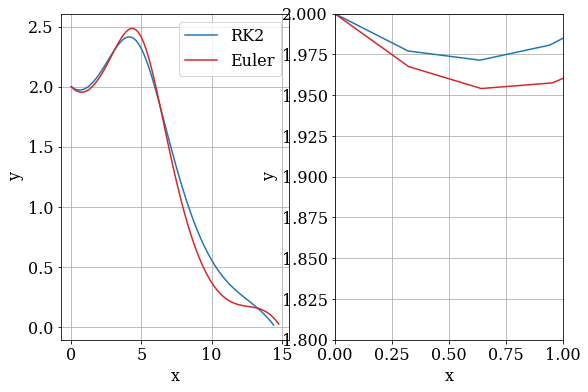

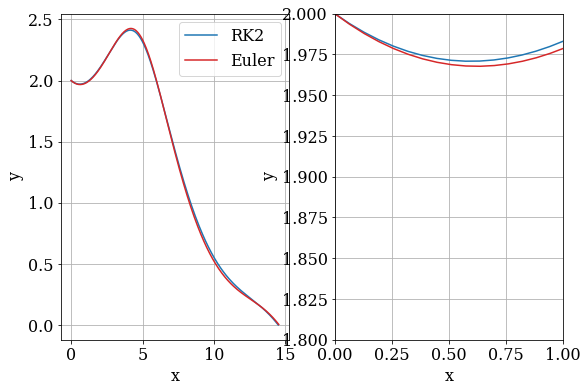

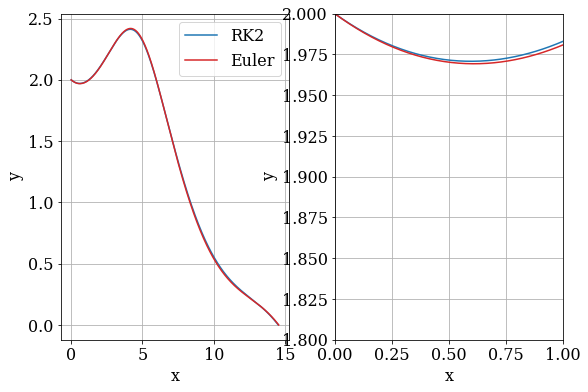

In [70]:
plot_combined_rk2_euler(15.0)

nother way to bring more information about $f(u)$ into the numerical solution is to look at time data $t\lt t_{n}$. For example, we can involve in the calculation of the solution $u_{n+1}$ the known solution at $u_{n-1}$, in addition to $u_{n}$. Schemes that use this idea are called _multi-step methods_.


A classical multi-step method achieves second order by applying a _centered difference_ approximation of the derivative $u'$:

$$
u'(t) \approx \frac{u_{n+1} - u_{n-1}}{2\Delta t}
$$

Isolate the future value of the solution $u_{n+1}$ and apply the differential equation $u'=f(u)$, to get the following formula for this method:

$$
u_{n+1} = u_{n-1} + 2\Delta t \, f(u_n)
$$

This scheme is known as the **leapfrog method**. Notice that it is using the right-hand side of the differential equation, $f(u)$, evaluated at the _midpoint_ between $u_{n-1}$ and $u_{n+1}$, where the time interval between these two solutions is $2\Delta t$. Why is it called "leapfrog"? If you imagine for a moment all of the _even_ indices $n$ of the numerical solution, you notice that these solution values are computed using the slope estimated from _odd_ values $n$, and vice-versa.

Let's define a function that computes the numerical solution using the leapfrog method:

In [80]:
def leapfrog_step(u_prev, u, f, dt, *args):
    """
    Returns the solution at the next time step using 
    the leapfrog method.
    
    Parameters
    ----------
    u_prev : numpy.ndarray
        Solution at the time step n-1
        as a 1D array of floats.
    u : numpy.ndarray
        Solution at the previous time step
        as a 1D array of floats.
    f : function
        Function to compute the right-hand side of the system.
    dt : float
        Time-step size.
    args : tuple, optional
        Positional arguments to pass to the function f.
    
    Returns
    -------
    u_new : numpy.ndarray
        The solution at the next time step
        as a 1D array of floats.
    """
    u_new = u_prev + 2.0 * dt * f(u, *args)
    return u_new

But wait ... what will we do at the initial time step, when we don't have information for  𝑢𝑛−1 ? This is an issue with all multi-step methods: we say that they are not self-starting. In the first time step, we need to use another method to get the first "kick"—either Euler's method or 2nd-order Runge Kutta could do: let's use RK2, since it's also second order.

For this calculation, we are going to re-enter the model parameters in the code cell below, so that later on we can experiment here using the leapfrog method and different starting values. At the end of this notebook, we'll give you some other model parameters to try that will create a very interesting situation!

In [111]:
# Set parameters.
g = 9.81  # gravitational acceleration (m.s^{-2})
vt = 4.9  # trim velocity (m.s)
CD = 1.0 / 5.0  # drag coefficient
CL = 1.0  # lift coefficient

# Set initial conditions.
v0 = 6.5  # start at the trim velocity
theta0 = -0.1  # trajectory angle
x0 = 0.0  # horizontal position
y0 = 5.0  # vertical position (altitude)

T = 35.0  # length of the time interval
dt = 0.01  # time-step size
N = int(T / dt) + 1  # number of time steps

# Create arrays to store the solution at each time step.
u_leapfrog = numpy.empty((N, 4))
# Set the initial conditions.
u_leapfrog[0] = numpy.array([v0, theta0, x0, y0])
# Use the RK2 method for the first time step.
u_leapfrog[1] = rk2_step(u_leapfrog[0], rhs_phugoid, dt, CL, CD, g, vt)

In [112]:
# Time integration using the leapfrog method.
for n in range(1, N - 1):
    u_leapfrog[n + 1] = leapfrog_step(u_leapfrog[n - 1], u_leapfrog[n],
                                      rhs_phugoid, dt, CL, CD, g, vt)

In [113]:
# Get the glider's position over the time.
x_leapfrog = u_leapfrog[:, 2]
y_leapfrog = u_leapfrog[:, 3]

# Get the index of the first negative element of y_leapfrog.
idx_negative_leapfrog = numpy.where(y_leapfrog < 0.0)[0]
if len(idx_negative_leapfrog) == 0:
    idx_ground_leapfrog = N - 1
    print('[leapfrog] Glider has not touched ground yet!')
else:
    idx_ground_leapfrog = idx_negative_leapfrog[0]

Distance traveled: 28.967


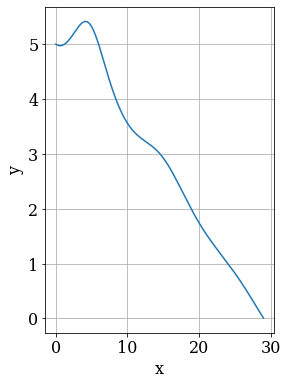

In [115]:
print('Distance traveled: {:.3f}'.format(x_leapfrog[idx_ground_leapfrog - 1]))

# Plot the glider's path for the leapfrog scheme.
pyplot.figure(figsize=(9.0, 6.0))
pyplot.subplot(121)
pyplot.grid()
pyplot.xlabel('x')
pyplot.ylabel('y')
pyplot.plot(x_leapfrog[:idx_ground_leapfrog],
            y_leapfrog[:idx_ground_leapfrog])
# Let's take a closer look!
#pyplot.subplot(122)
#pyplot.grid()
#pyplot.xlabel('x')
#pyplot.ylabel('y')
#pyplot.plot(x_leapfrog, y_leapfrog)
#pyplot.xlim(0.0, 5.0)
#pyplot.ylim(1.8, 2.5);

In [87]:
r = 2  # time-step size refinement ratio
h = 0.001  # finest time-step size

dt_values = [h, r * h, r**2 * h]
u_values = []

for dt in dt_values:
    N = int(T / dt) + 1  # number of time steps
    # Set initial conditions.
    u = numpy.empty((N, 4))
    u[0] = numpy.array([v0, theta0, x0, y0])
    # Use RK2 for the first time step.
    u[1] = rk2_step(u[0], rhs_phugoid, dt, CL, CD, g, vt)
    # Time integration using the leapfrog scheme.
    for n in range(1, N - 1):
        u[n + 1] = leapfrog_step(u[n - 1], u[n], rhs_phugoid, dt,
                                 CL, CD, g, vt)
    # Store the solution for the present time grid.
    u_values.append(u)

# Compute the observed order of convergence.
p = (math.log(l1_diff(u_values[2][:, 2], u_values[1][:, 2],
                      dt_values[2]) /
              l1_diff(u_values[1][:, 2], u_values[0][:, 2],
                      dt_values[1])) /
     math.log(r))

print('Observed order of convergence: p = {:.3f}'.format(p))

Observed order of convergence: p = 2.187


We now have numerical evidence that our calculation with the leapfrog method indeed exhibits second-order convergence, i.e., the method is  ${\mathcal O}(\Delta t^2)$. . The leapfrog method is a second-order method.